In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import zipfile, os

# 1. Data Preparation

In [2]:
# download the file bash
!wget https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip

--2021-07-20 14:20:48--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘rockpaperscissors.zip.2’

rockpaperscissors.z 100%[===================>] 307.92M  7.49MB/s    in 80s     

2021-07-20 14:22:09 (3.85 MB/s) - ‘rockpaperscissors.zip.2’ saved [322873683/322873683]



In [3]:
# unzip file

local_zip = 'rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('sample_data_dicoding')
zip_ref.close()

In [4]:
base_dir = 'sample_data_dicoding/rockpaperscissors/rps-cv-images'
os.listdir(base_dir)

['rock', 'README_rpc-cv-images.txt', 'scissors', 'paper']

In [5]:
# check and delete corrupted files

num_skipped = 0
for folder_name in ('rock', 'scissors', 'paper'):
    folder_path = os.path.join(base_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_png = tf.compat.as_bytes("PNG") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_png:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


Image shape: (200, 300, 3)


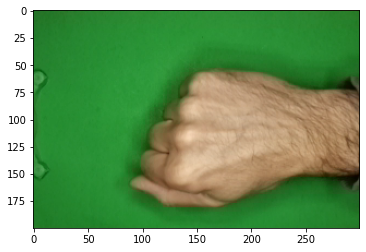

In [6]:
# checking sample image (and its shape)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

listfile = os.listdir('sample_data_dicoding/rockpaperscissors/rock/')
img = mpimg.imread('sample_data_dicoding/rockpaperscissors/rock/' + listfile[random.randint(1, len(listfile))])
print("Image shape:", img.shape)
imgplot = plt.imshow(img)
plt.show()

# 2. Data Pre-processing
with Image Augmentation
read more about Image Augmentatio example on [this](https://fairyonice.github.io/Learn-about-ImageDataGenerator.html) or [documentation](https://keras.io/api/preprocessing/image/)

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # rescale pixel value from 0-255 to 0-1
    rotation_range=20, # rotate image in range 0-20deg
    horizontal_flip=True, # flip image horizontally 
    shear_range=0.2, # shear angle in counter-clockwise direction 0.2deg
    fill_mode='wrap', 
    validation_split=0.4 # split 40% of the data into validation set
)

In [8]:
train_generator = train_datagen.flow_from_directory(
    base_dir, # target directory
    target_size=(100, 150), # resize all image from 200x300 to 100x150 px
    class_mode='categorical', # use categorical since there are 3 classes of image
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(100, 150),
    class_mode='categorical',
    subset='validation'
)

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


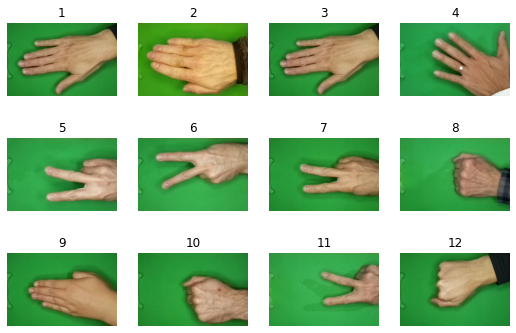

In [9]:
# print some random samples from train data

plt.figure(figsize=(9, 6))
for i in range(12):
  ax = plt.subplot(3, 4, i + 1)
  img = mpimg.imread(train_generator.filepaths[random.randint(0, len(train_generator.filepaths))])
  plt.imshow(img)
  plt.title(i+1)
  plt.axis("off")

# 3. Model Architecture
Build model architecture with **CNN Architecture**  
CNN consist of: input layer, convolutional layer, max-pooling layer, flatten layer, output layer.

In [10]:
model = tf.keras.models.Sequential([
                                   tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 150, 3)),
                                   tf.keras.layers.MaxPooling2D(2, 2),
                                   tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                                   tf.keras.layers.MaxPooling2D(2, 2),
                                   tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
                                   tf.keras.layers.MaxPooling2D(2, 2),
                                   tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
                                   tf.keras.layers.MaxPooling2D(2, 2),
                                   tf.keras.layers.Flatten(), # flattened to a 1D array
                                   tf.keras.layers.Dense(512, activation='relu'),
                                   tf.keras.layers.Dense(3, activation='softmax') # Softmax is used for multi-classification, whereas Sigmoid for binary-classification
])

model.summary() # good line to see a summary of our model's architecture

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 148, 32)       896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 15, 256)        2

# 4. Model Compile

In [11]:
model.compile(
    loss='categorical_crossentropy', # catagorical_crossentropy for multi-class, binary_crossentropy for binary-class
    optimizer='RMSprop', # some sources said that RMSprop is the best for recurrent neural networks, but as in my previous run, Adam is much faster (RMSprop took almost 10 minutes)
    metrics=['accuracy']
)

### Below is just improvement using Callback
Callback function will stop the training once the model has reached accuracy target or treshold.

In [12]:
accuracy_treshold = 0.96
class callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if logs.get('accuracy') > accuracy_treshold:
      print('\nEpoch {} and accuracy has reached {:.2f}, so training has been stopped.'.format(epoch, logs['accuracy']))
      self.model.stop_training = True

# 5. Model Train

In [13]:
history = model.fit( # store to a variable to create a training history
    train_generator,
    steps_per_epoch=25, # how many batch that will be executed per each epoch
    epochs=20, # number of epochs run
    validation_data=validation_generator, # accuracy of validation with validation data
    validation_steps=5,
    verbose=2,
    callbacks=[callback()]
)

Epoch 1/20
25/25 - 33s - loss: 1.5589 - accuracy: 0.3662 - val_loss: 1.0026 - val_accuracy: 0.7063
Epoch 2/20
25/25 - 32s - loss: 1.0592 - accuracy: 0.5805 - val_loss: 0.7894 - val_accuracy: 0.8000
Epoch 3/20
25/25 - 32s - loss: 0.5687 - accuracy: 0.7961 - val_loss: 0.4051 - val_accuracy: 0.8813
Epoch 4/20
25/25 - 32s - loss: 0.4107 - accuracy: 0.8429 - val_loss: 0.4316 - val_accuracy: 0.8500
Epoch 5/20
25/25 - 32s - loss: 0.3322 - accuracy: 0.8948 - val_loss: 0.2981 - val_accuracy: 0.9125
Epoch 6/20
25/25 - 32s - loss: 0.3010 - accuracy: 0.8935 - val_loss: 0.2936 - val_accuracy: 0.8875
Epoch 7/20
25/25 - 33s - loss: 0.2383 - accuracy: 0.9175 - val_loss: 0.1682 - val_accuracy: 0.9500
Epoch 8/20
25/25 - 32s - loss: 0.2219 - accuracy: 0.9247 - val_loss: 0.5867 - val_accuracy: 0.7063
Epoch 9/20
25/25 - 32s - loss: 0.2125 - accuracy: 0.9156 - val_loss: 0.1096 - val_accuracy: 0.9625
Epoch 10/20
25/25 - 32s - loss: 0.2084 - accuracy: 0.9338 - val_loss: 0.1806 - val_accuracy: 0.9375
Epoch 11/

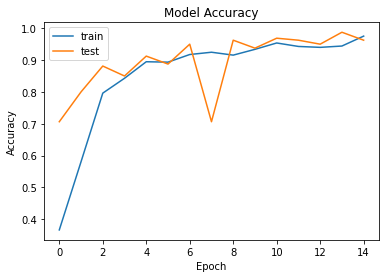

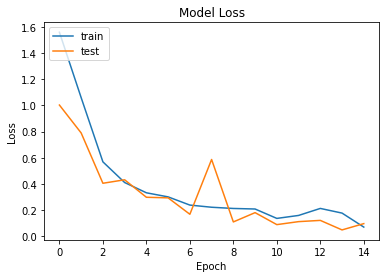

In [14]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 6. Model Test (Prediction)

Saving photo_2021-07-20_18-05-20.jpg to photo_2021-07-20_18-05-20 (2).jpg
photo_2021-07-20_18-05-20.jpg
rock


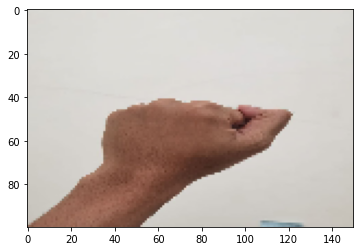

In [15]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(100,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes[0, 0]==1:
    print('rock')
  elif classes[0, 1]==1:
    print('paper')
  elif classes[0, 2]==1:
    print('scissors')